In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import IPython
import matplotlib.pyplot as plt
from torchaudio.io import StreamReader

2.8.0+cu128
2.8.0+cu128


EMFORMER_RNNT_BASE_LIBRISPEECH は訓練済みモデル。
Emformerは低遅延ストリーミング音声認識のための、メモリ効率的なTransformerの変種。

In [4]:
bundle = torchaudio.pipelines.EMFORMER_RNNT_BASE_LIBRISPEECH

feature_extractor = bundle.get_streaming_feature_extractor()
decoder = bundle.get_decoder()
token_processor = bundle.get_token_processor()

ストリーミング推論は、入力データのオーバーラップを許している。Emformer RNN-Tは最も新しいデータを右側に配置する。

各推論呼び出しで、末尾の幾らかの部分をRight Contextとして扱い、それはキャッシュされて次回の入力の先端となる。なお、初回は前回のRight Contextがないのでゼロが渡る。

In [5]:
sample_rate = bundle.sample_rate
segment_length = bundle.segment_length * bundle.hop_length
context_length = bundle.right_context_length * bundle.hop_length

print(f"Sample rate: {sample_rate}")
print(f"Main segment: {segment_length} frames ({segment_length / sample_rate} seconds)")
print(
    f"Right context: {context_length} frames ({context_length / sample_rate} seconds)"
)

Sample rate: 16000
Main segment: 2560 frames (0.16 seconds)
Right context: 640 frames (0.04 seconds)


In [6]:
src = "https://download.pytorch.org/torchaudio/tutorial-assets/greatpiratestories_00_various.mp3"

streamer = StreamReader(src)
streamer.add_basic_audio_stream(
    frames_per_chunk=segment_length, sample_rate=bundle.sample_rate
)

print(streamer.get_src_stream_info(0))
print(streamer.get_out_stream_info(0))

SourceAudioStream(media_type='audio', codec='mp3', codec_long_name='MP3 (MPEG audio layer 3)', format='fltp', bit_rate=128000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=44100.0, num_channels=2)
OutputAudioStream(source_index=0, filter_description='aresample=16000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=16000.0, num_channels=2)


/tmp/ipykernel_87908/711624023.py:3: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  streamer = StreamReader(src)


In [7]:
class ContextCacher:
    """Cache the end of input data and prepend the next input data with it.

    Args:
        segment_length (int): The size of main segment.
            If the incoming segment is shorter, then the segment is padded.
        context_length (int): The size of the context, cached and appended.
    """

    def __init__(self, segment_length: int, context_length: int):
        self.segment_length = segment_length
        self.context_length = context_length
        self.context = torch.zeros([context_length])

    def __call__(self, chunk: torch.Tensor):
        if chunk.size(0) < self.segment_length:
            chunk = torch.nn.functional.pad(
                chunk, (0, self.segment_length - chunk.size(0))
            )
        chunk_with_context = torch.cat((self.context, chunk))
        self.context = chunk[-self.context_length :]
        return chunk_with_context


In [8]:
cacher = ContextCacher(segment_length, context_length)

state, hypothesis = None, None

In [9]:
stream_iterator = streamer.stream()


def _plot(feats, num_iter, unit=25):
    unit_dur = segment_length / sample_rate * unit
    num_plots = num_iter // unit + (1 if num_iter % unit else 0)
    fig, axes = plt.subplots(num_plots, 1)
    t0 = 0
    for i, ax in enumerate(axes):
        feats_ = feats[i * unit : (i + 1) * unit]
        t1 = t0 + segment_length / sample_rate * len(feats_)
        feats_ = torch.cat(
            [f[2:-2] for f in feats_]
        )  # remove boundary effect and overlap
        ax.imshow(feats_.T, extent=[t0, t1, 0, 1], aspect="auto", origin="lower")
        ax.tick_params(which="both", left=False, labelleft=False)
        ax.set_xlim(t0, t0 + unit_dur)
        t0 = t1
    fig.suptitle("MelSpectrogram Feature")
    plt.tight_layout()


@torch.inference_mode()
def run_inference(num_iter=100):
    global state, hypothesis
    chunks = []
    feats = []
    for i, (chunk,) in enumerate(stream_iterator, start=1):
        segment = cacher(chunk[:, 0])
        features, length = feature_extractor(segment)
        hypos, state = decoder.infer(
            features, length, 10, state=state, hypothesis=hypothesis
        )
        hypothesis = hypos
        transcript = token_processor(hypos[0][0], lstrip=False)
        print(transcript, end="\r", flush=True)

        chunks.append(chunk)
        feats.append(features)
        if i == num_iter:
            break

    # Plot the features
    _plot(feats, num_iter)
    return IPython.display.Audio(torch.cat(chunks).T.numpy(), rate=bundle.sample_rate)

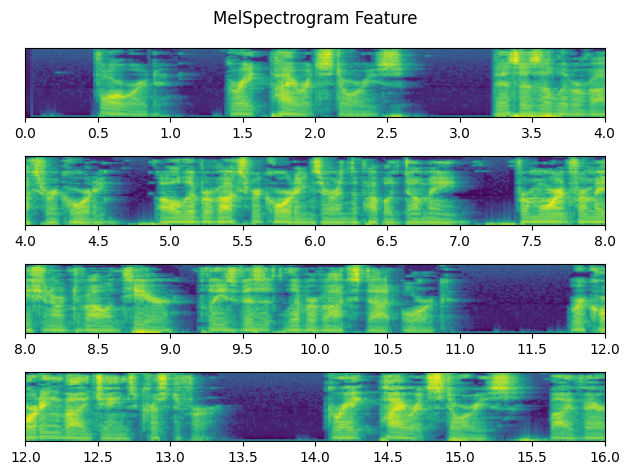

In [10]:
run_inference()
